In [1]:
import numpy as np
a = np.ones((5, 4))
np.sum(a, axis=-1)

array([4., 4., 4., 4., 4.])

In [2]:
import os
import pandas as pd
d = pd.read_csv("PAMAP2_Dataset/Protocol/subject101.dat", sep=" ", header=None)



<Axes: >

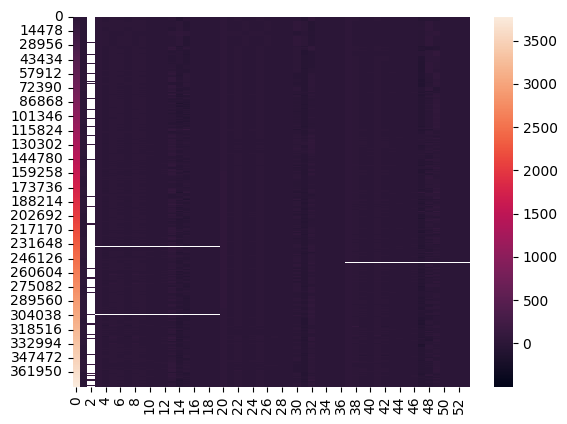

In [3]:
import seaborn as sns
sns.heatmap(d)

In [4]:
d = d.dropna(axis=0, how='any')

In [5]:
grouped = d.groupby(1)
n_activities = grouped.ngroups
processed = grouped.head(10).drop(0, axis=1)

In [6]:
processed.to_csv("processed_101.csv", sep=" ", header=None, index=False)

In [7]:
from sklearn.mixture import GaussianMixture


def cluster(df, n):
    gmm = GaussianMixture(n_components=n).fit(df)
    return gmm.predict(df)


labels = cluster(processed, n_activities)

In [8]:
labels

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 12,
       12, 12, 12, 12, 12, 12,  0,  0,  0,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8])

# Own implementation

In [17]:
# python based GMM
import numpy as np
from scipy.stats import multivariate_normal
from dataclasses import dataclass

@dataclass
class ClusterHyperparams:
    alpha: float
    beta: float
    m: float
    nu: float
    W: float

def gmm(n_components, data: np.ndarray, mixture_means = None, mixture_sigma = None, mixture_weights = None):
    num_records, D = data.shape
    
    
    if mixture_means is None:
        mixture_means =  np.array([[ 0.78427395, 0.6372403],
                                    [0.18992559, 0.49756259],
                                    [0.25944241, 0.19840927]])
        # np.random.random((n_components, D))
    if mixture_sigma is None:
        mixture_sigma =  np.zeros((n_components, D, D))
        for i in range(n_components):
            mixture_sigma[i] = np.eye(D)
    if mixture_weights is None:
        mixture_weights = np.array([0.07812915
                                  , 0.78055305
                                  , 0.42758881])
        # np.random.random(n_components)
    
    responsibilities = np.zeros((num_records, n_components))


    # expectation step
    for c in range(n_components):
        probabilities = multivariate_normal.pdf(data, mixture_means[c], mixture_sigma[c])
        responsibilities[:, c] = mixture_weights[c] * probabilities
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)

#    190.06783873, 319.50148005,  90.43068122]
    # maximization step
    sum_responsibilities = responsibilities.sum(axis=0)
    mixture_weights = sum_responsibilities / num_records
    mixture_means = (responsibilities.T @ data) / sum_responsibilities[:, None]
    for c in range(n_components):
        j = np.expand_dims(data, axis=1) - mixture_means[c]
        s = j.transpose(0, 2, 1) @ j
        mixture_sigma[c] = (s.transpose(1, 2, 0) @ responsibilities[:, c]) / sum_responsibilities[c]
    
    return mixture_means, mixture_sigma, mixture_weights

In [18]:

from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

def plot_gaussian(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            edgecolor='k')
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

def draw(ax, k, mu, sigma, n_std=2.0, facecolor='none', **kwargs):
    '''
    Function to draw the Gaussians.
    Note: Only for two-dimensionl dataset
    '''
    for i in range(k):
        plot_gaussian(mu[i], sigma[i], ax, n_std=n_std, **kwargs)

def plot(X, n_components, mu, sigma):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(mu[:, 0], mu[:, 1])
    draw(ax, n_components, mu, sigma, lw=3)
    ax.set_xlim((-12, 12))
    ax.set_ylim((-12, 12))
    
    plt.show()
    plt.clf()

def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = np.random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    return x

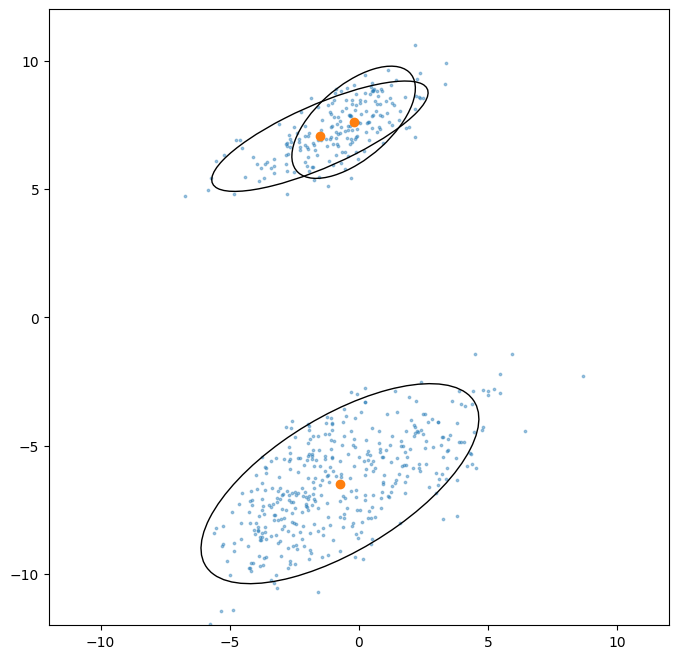

<Figure size 640x480 with 0 Axes>

In [19]:
num_iters = 100
n_components = 3
X = np.loadtxt("data.csv", delimiter=",")
# gen_data()
mixture_means, mixture_sigma, mixture_weights = (None,) * 3
for k in range(num_iters):
    mixture_means, mixture_sigma, mixture_weights = gmm(n_components, X, mixture_means, mixture_sigma, mixture_weights)

plot(X, n_components, mixture_means, mixture_sigma)
    

# Test

## Sequential

nvcc main.cpp EM.cpp ../linalg/vector.cpp ../linalg/matrix.cpp ../linalg/errors.cpp ../linalg/util.cpp ../linalg/linsolve.cpp ../linalg/eigen.cpp ../linalg/linreg.cpp ../linalg/rand.cpp utils.cpp stats.cpp -o mixture_models -g
./sequential/mixture_models data.csv 3 600 2 means sigma 100


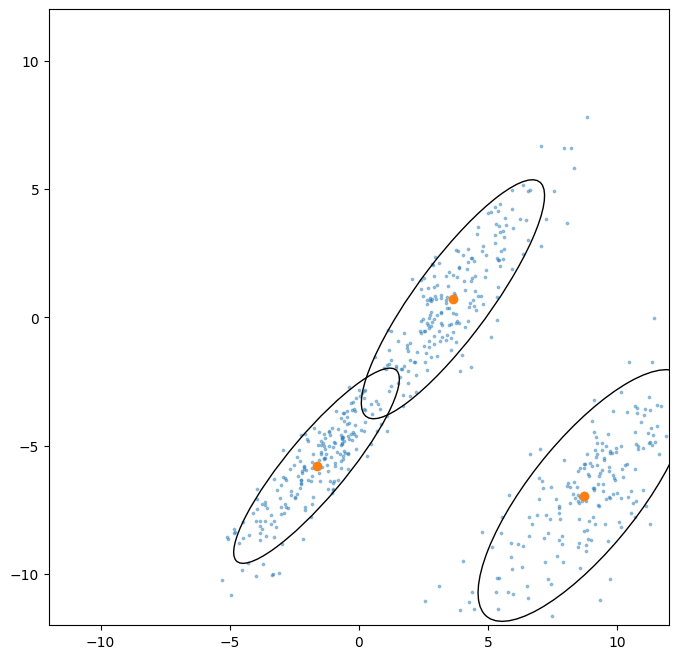

<Figure size 640x480 with 0 Axes>

In [24]:
import os 
target_dir = 'sequential'
file_name, out_name, means, sigma = "data.csv", "mixture_models", "means", "sigma"
n_components, D = 3, 2
X = gen_data(n_components, D)
size = X.shape[0]
np.savetxt(file_name, X, delimiter=",")
os.system(f"cd {target_dir}; make --always-make")
command = f"./{target_dir}/{out_name} {file_name} {n_components} {size} {D} {means} {sigma} {num_iters}"
print(command)
os.system(command)
mixture_means = np.loadtxt(means, delimiter=",")
# For mixture sigma components are stacked vertically
mixture_sigma = np.loadtxt(sigma, delimiter=",").reshape(n_components, D, D)
plot(X, n_components, mixture_means, mixture_sigma)


In [25]:
## Parallel

sending incremental file list
data.csv
parallelized/
parallelized/means
parallelized/sigma

sent 15,892 bytes  received 378 bytes  10,846.67 bytes/sec
total size is 3,607,598  speedup is 221.73
/user/2/.base/forostib/home/project/parallelized
build_on_device.sh
cudaTimer.cu
EM.cu
EM.h
main.cu
Makefile
means
mixture_models
sigma
stats.cu
stats.h
utils.cu
utils.h
nvcc main.cu EM.cu ../linalg/vector.cpp ../linalg/matrix.cpp ../linalg/errors.cpp ../linalg/util.cpp ../linalg/linsolve.cpp ../linalg/eigen.cpp ../linalg/linreg.cpp ../linalg/rand.cpp utils.cu stats.cu -o mixture_models -g


make: Warning: File 'mixture_models' has modification time 98 s in the future
make: warning:  Clock skew detected.  Your build may be incomplete.


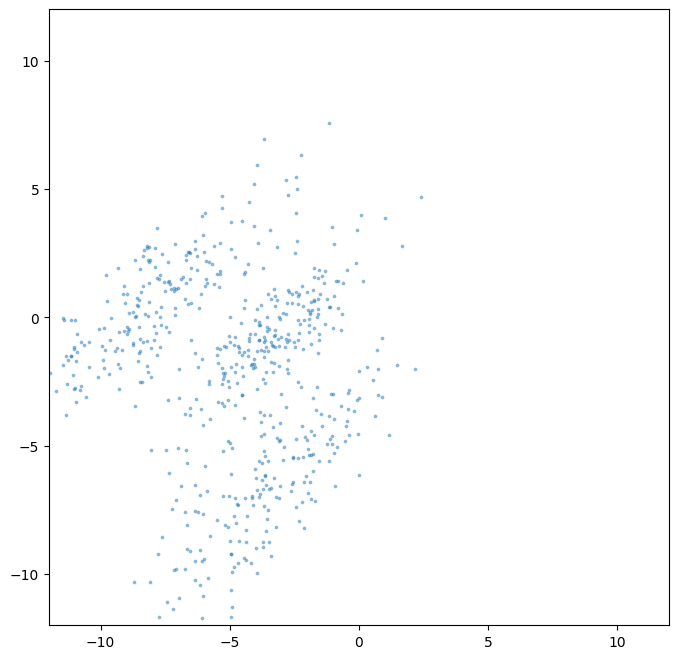

<Figure size 640x480 with 0 Axes>

In [29]:
import os 
target_dir = 'parallelized'
file_name, out_name, means, sigma = "data.csv", "mixture_models", "means", "sigma"
n_components, D = 3, 2
X = np.loadtxt("data.csv", delimiter=",")
# gen_data(n_components, D)
size = X.shape[0]
np.savetxt(file_name, X, delimiter=",")
os.system(f"cd {target_dir}; ./build_on_device.sh")
mixture_means = np.loadtxt(f'{target_dir}/{means}', delimiter=",")
# For mixture sigma components are stacked vertically
mixture_sigma = np.loadtxt(f'{target_dir}/{sigma}', delimiter=",").reshape(n_components, D, D)
plot(X, n_components, mixture_means, mixture_sigma)


In [ ]:
A = np.ones((256,256, 3))
np.savetxt("sigma", np.ones((9,3)))
np.savetxt("means", np.ones((3,3)))


In [ ]:
for arr in (np.ones((9, 3)) * np.arange(9)[:, None]).reshape(3, 3, 3):
    print(arr)
    print("----")

[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]]
----
[[3. 3. 3.]
 [4. 4. 4.]
 [5. 5. 5.]]
----
[[6. 6. 6.]
 [7. 7. 7.]
 [8. 8. 8.]]
----
